# Massachusetts IT Data Exercise
## Farmers Markets exploration: where are they?
### In this notebook I'll explore where Farmers Markets in Massachusets are located. Is it only in affluent areas? Are they only near Boston?

### Let's set up and see what the dataset looks like

In [1]:
#Setting up notebook stuff, imports and declarations
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import requests
import pandas as pd
import seaborn as sb
import geopandas as gpd

FM_API = 'https://data.mass.gov/resource/66t5-f563.json'
MAP_API = 'https://data.mass.gov/resource/pyyd-nyhx.json'
census_API_key = "023709ad05870613b32186486d625cf41c6f2ac2"
MASS_CRS = 26986

In [2]:
# Get the dataset and see what it looks like
try:
    df_fm = pd.read_json(FM_API)
    df_fm.head(2)
except:
    print("Importing data failed. Are you online?")

,:@computed_region_kq4j_wjar,addr_1,addr_2,coupons,dates,day_time,ebt,location,market_id,name,town,type,update_dat,website,year_start,zip_code
0,1913.0,11 Wilbraham Road,Mason Sq. Health Center,WIC & Senior Coupons Accepted,July 11 to October 31,"Saturday, 10:00 am - 2:00 pm",EBT-SNAP Accepted,"{'type': 'Point', 'coordinates': [-72.56369, 4...",170,Springfield/Mason Square,Springfield,Farmers Markets,2015,http://www.facebook.com/pages/Mason-Square-Far...,2007.0,1129
1,1918.0,525 River St.,Church of the Holy Sprit Parking Lot,WIC & Senior Coupons Accepted,July 11 to October 10,"Saturday, 10:00 am - 2:00 pm",EBT-SNAP Accepted,"{'type': 'Point', 'coordinates': [-71.09473, 4...",172,Mattapan,Mattapan,Farmers Markets,2015,NaN,2007.0,2126


### Probably better to visualize as a map to get a sense of geographical concentration

In [3]:
# Shapefiles from http://www.mass.gov/anf/research-and-tech/it-serv-and-support/application-serv/office-of-geographic-information-massgis/datalayers/zipcodes.html
geo_df = gpd.read_file('ZIPCODES_NT_POLY.shp')
plot = geo_df.to_crs(epsg=MASS_CRS)
geo_df['zipnum'] = pd.to_numeric(geo_df['POSTCODE'])
geo_merge = geo_df.join(df_fm.zip_code.value_counts(),on='zipnum', how='left')
geo_merge['zip_code'].fillna(0,inplace=True)
geo_merge = geo_merge.rename(columns={'zip_code':'fmarkets_count'})


In [4]:
# How concentrated are they?
geo_merge.fmarkets_count.value_counts()/len(geo_merge)

0.0    0.578846
1.0    0.315385
2.0    0.080769
3.0    0.017308
4.0    0.005769
5.0    0.001923
Name: fmarkets_count, dtype: float64

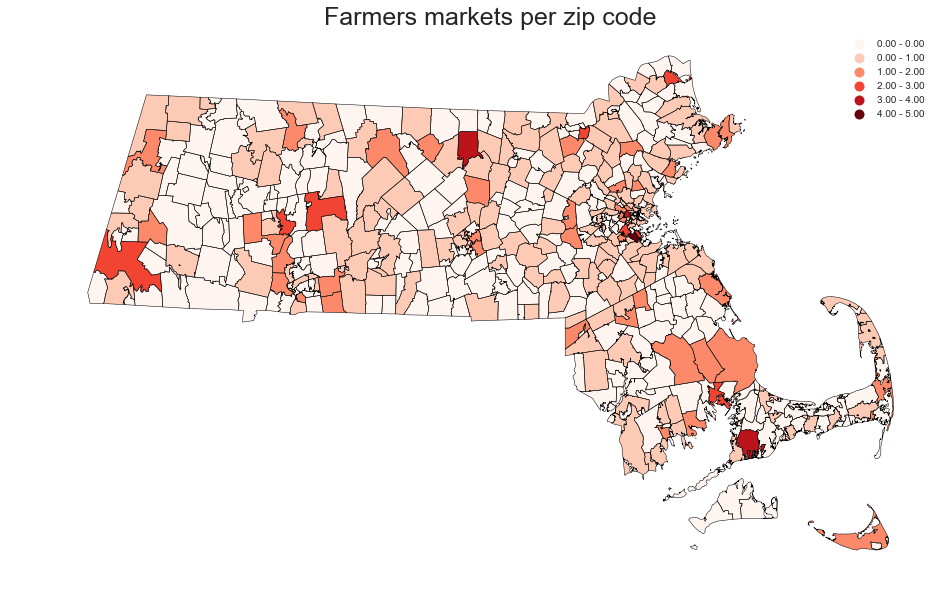

In [5]:
fmarkets_plot=geo_merge.plot(column='fmarkets_count',cmap='Reds', alpha = 1, linewidth = 0.5, figsize = (16, 10), \
                    legend=True, scheme = 'fisher_jenks', k = 6)
fmarkets_plot.set_title("Farmers markets per zip code", fontsize=25)
fmarkets_plot.set_axis_off()

### Interesting. While there are many zip code areas that do not have farmers markets, they don't seem to be particularly concentrated geographically. 

### Now let's merge this information about Farmet Market locations with data from the American Community Survey 5-year estimates

In [6]:
## Estabilishing variables of interest

acs_var_dict = {'B19013_001E' : "income",
                'B19301_001E': "income_per_capita",
                'B23025_002E': "employment_labor_force",
                'B17001_002E' : "poverty",
                'B01002_001E' : "median_age",
                'B01003_001E' : "population",
                'B02001_002E' : "white",
                'B02001_003E' : "black",
                'B02001_005E' : "asian",
                'B03001_003E' : "hispanic_origin",
                'B25077_001E' : "median_home_value"}

In [7]:
# Get a list of the zipcodes of interest (all zip codes in MA) and call the API
mass_zips = ",".join(geo_df['POSTCODE'].tolist())
acs_vars = ",".join(list(acs_var_dict.keys()))
acs_response = requests.get('http://api.census.gov/data/2015/acs5?get={}&for=zip+code+tabulation+area:{}&key={}'.\
                            format(acs_vars, mass_zips, census_API_key)).json()
acs_df = pd.DataFrame(acs_response[1:], columns = acs_response[0])

In [8]:
# Make the dataframe more understandable
acs_df = acs_df.rename(columns=acs_var_dict)
acs_df = acs_df.rename(columns={'zip code tabulation area':'zcta'})
acs_df = acs_df.set_index('zcta')
acs_df = acs_df.apply(pd.to_numeric, errors='coerce')

In [9]:
# Obtain demographics by share of the population instead of full numbers
acs_df['white_share'] = acs_df.white/acs_df.population
acs_df["black_share"] = acs_df.black/acs_df.population
acs_df['asian_share'] = acs_df.asian/acs_df.population
acs_df['hispanic_share'] = acs_df.hispanic_origin/acs_df.population
acs_df['employed_share'] = acs_df.employment_labor_force/acs_df.population
acs_df.head(2)

,income,income_per_capita,employment_labor_force,poverty,median_age,population,white,black,asian,hispanic_origin,median_home_value,white_share,black_share,asian_share,hispanic_share,employed_share
zcta,,,,,,,,,,,,,,,,
01001,60161.0,30044,9600,1248,44.5,17438,16014,230,639,1118,203700.0,0.918339,0.013190,0.036644,0.064113,0.550522
01002,50540.0,26130,16276,8124,23.4,29780,23333,1399,3853,1919,342600.0,0.783512,0.046978,0.129382,0.064439,0.546541


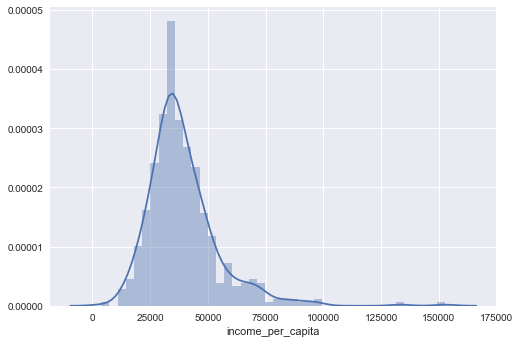

In [10]:
#let's look at the distribution of income per capita per zipcode
sb.distplot(acs_df.income_per_capita)

## We now plot to explore the ACS income data

In [11]:
# Merge our data
geo_merge = geo_merge.join(acs_df, on='POSTCODE', how='inner')


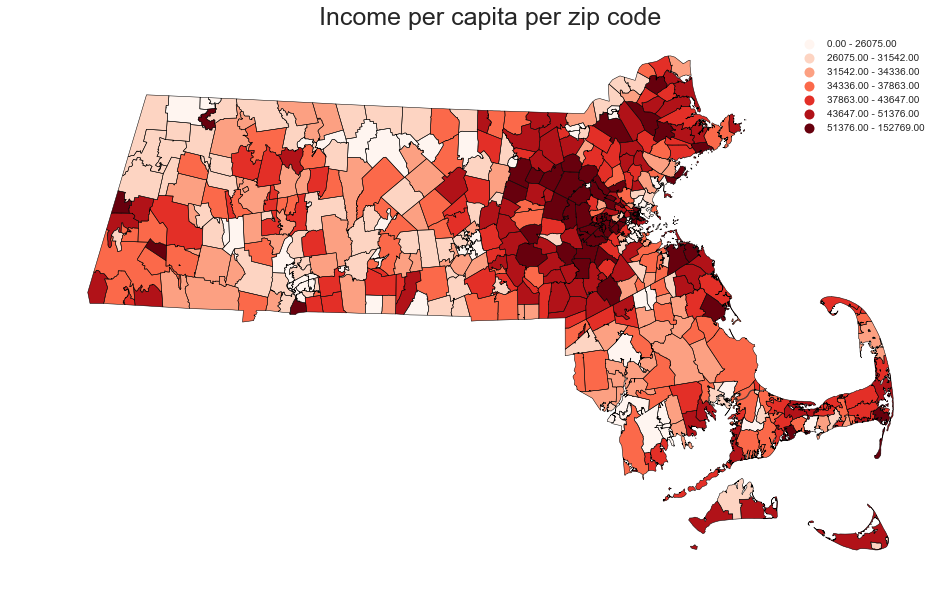

In [12]:
plot=geo_merge.plot(column='income_per_capita',cmap='Reds', alpha = 1, linewidth = 0.5, figsize = (16, 10), \
                    legend=True, scheme = 'quantiles', k = 7)
plot.set_title("Income per capita per zip code", fontsize=25)

plot.set_axis_off()

## Having both sources, we can attempt to plot a multivariate cloropleth map to see whether it's apparent they're correlated 

(19023.401815001664,
 345646.83048499672,
 768511.10552500119,
 968847.37957499991)

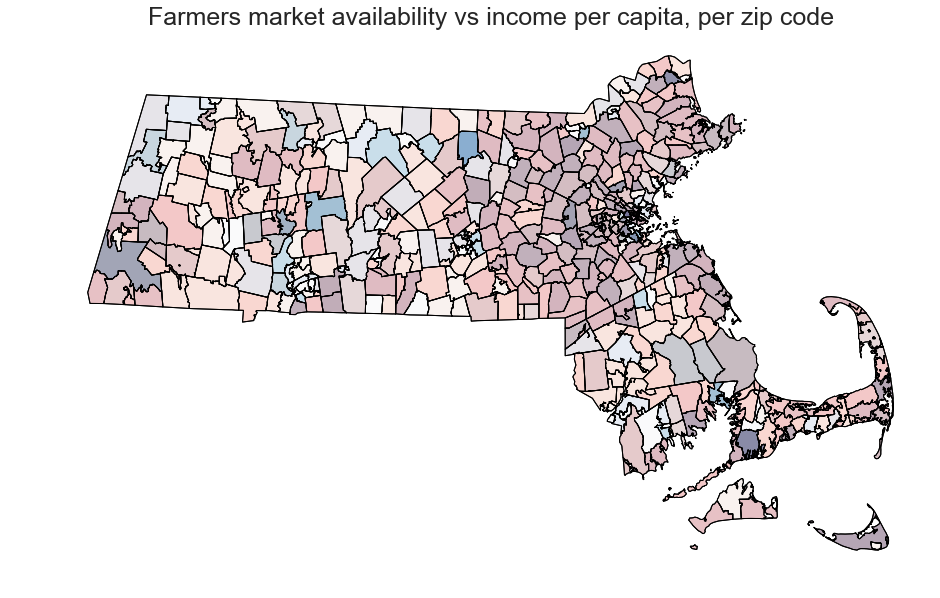

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 10))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


geo_merge.plot(ax=ax, column='income_per_capita',cmap='Reds', #alpha = 1, linewidth = 0.5, \
                    legend=False, scheme = 'quantiles', k = 7)
ax.set_title("Farmers market availability vs income per capita, per zip code", fontsize=25)

geo_merge.plot(ax=ax, column='fmarkets_count',cmap='Blues', #alpha = 1, linewidth = 0.5, \
                    legend=False, scheme = 'fisher_jenks', k = 6)
ax.set_axis_off()
plt.axis('off')
plt.show()

## Finallly, we get the actual correlation on income and other demographic variables

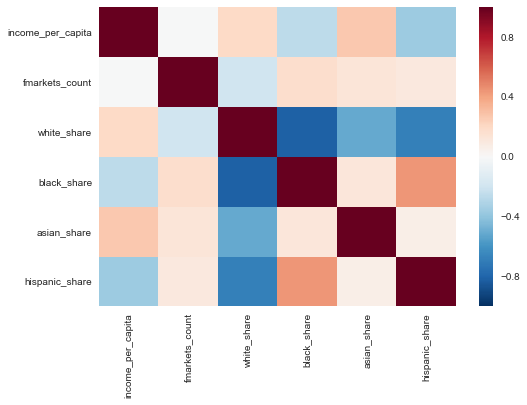

In [14]:
corr_df = geo_merge[['income_per_capita','fmarkets_count','white_share','black_share','asian_share','hispanic_share']].corr()
sb.heatmap(corr_df)

In [15]:
corr_df

,income_per_capita,fmarkets_count,white_share,black_share,asian_share,hispanic_share
income_per_capita,1.000000,-0.000901,0.201035,-0.259306,0.266276,-0.362383
fmarkets_count,-0.000901,1.000000,-0.198363,0.175598,0.129400,0.108461
white_share,0.201035,-0.198363,1.000000,-0.814615,-0.511059,-0.683706
black_share,-0.259306,0.175598,-0.814615,1.000000,0.121848,0.440060
asian_share,0.266276,0.129400,-0.511059,0.121848,1.000000,0.065930
hispanic_share,-0.362383,0.108461,-0.683706,0.440060,0.065930,1.000000


### There is no correlation.
#### Interestingly, there is a strong negative correlation between white share of the population and other shares, hinting segregation. 
#### Furthermore, there is a weak negative correlation between farmers markets and white share of the population (and a weak correlation between non-white shares and farmers markets). Maybe worth exploring more rigorously.

### Extras: farmers market age

In [16]:
df_fm.sort_values('year_start').year_start.value_counts()

2009.0    26
2010.0    25
2012.0    24
2013.0    24
2011.0    23
2014.0    22
2008.0    17
2007.0    13
2015.0    12
2006.0    10
2005.0     8
1996.0     8
2003.0     7
1979.0     5
1978.0     5
1984.0     4
1995.0     4
1988.0     3
2004.0     3
2002.0     3
1990.0     3
1998.0     3
1976.0     3
2001.0     2
1994.0     2
1980.0     2
1997.0     2
1975.0     2
1982.0     1
1985.0     1
1970.0     1
1971.0     1
1987.0     1
1977.0     1
1974.0     1
1991.0     1
1950.0     1
1934.0     1
Name: year_start, dtype: int64